In [1]:
%matplotlib inline

In [2]:
# Third party imports 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from obspy.io.quakeml.core import Unpickler
import pandas as pd

# Local imports
from libcomcat.dataframes import get_phase_dataframe, get_magnitude_data_frame
from libcomcat.search import get_event_by_id

# Contents
----
- [Getting All Magnitudes](#Getting-All-Magnitudes)
- [Getting All DYFI responses](#Getting-All-DYFI-responses)

## Getting All Magnitudes


A lot of the information about locations and magnitudes can only be found in the QuakeML XML file for an origin or phase-data product. However, it isn't necessary to know how to parse XML in order to extract this information, as Obspy can easily parse the information. In the cells below the *Unpickler* class is used to create an <a href="https://docs.obspy.org/packages/autogen/obspy.core.event.Catalog.html">Obspy Catalog</a> object, which can be easily inspected for events, magnitudes, origins, picks, etc.

In [3]:
eventid = 'nc73201181'
detail = get_event_by_id(eventid, includesuperseded=True)

In [9]:
unpickler = Unpickler()
us_origins = detail.getProducts('phase-data', source='us', version='all')
maglist = []
mtypes = []
for origin in us_origins:
    version = origin.version
    qbytes, url = origin.getContentBytes('xml')
    catalog = unpickler.loads(qbytes)
    mdict = {'version':version}
    for magnitude in catalog.events[0].magnitudes:
        magtype = magnitude.magnitude_type
        if magtype not in mtypes:
            mtypes.append(magtype)
        magvalue = magnitude.mag
        mdict[magtype] = magvalue
    maglist.append(mdict)

magframe = pd.DataFrame(data=maglist)

magframe['version'] = magframe['version'].astype(np.int32)
print('US Magnitudes by version for event %s:' % detail.id)
magframe

US Magnitudes by version for event nc73201181:


,version,ML,Mwr,mb,Mww,Ms_20,Mwb
0,1,5.5,5.6,5.4,5.6,5.2,NaN
1,2,5.3,5.6,5.4,5.6,5.4,5.6
2,3,5.3,5.6,5.4,5.6,5.4,5.6
3,4,5.4,5.6,5.4,5.6,5.4,5.6
4,5,5.4,5.6,5.4,5.6,5.4,5.6
5,6,5.4,5.6,5.4,5.6,5.4,5.6


## Getting All DYFI responses

The above detail event can be used to reproduce the responses vs time plot found [HERE](https://earthquake.usgs.gov/earthquakes/eventpage/nc73201181/dyfi/responses-vs-time).

(and add a red vertical line to show when 95% of all responses have occurred)

In [10]:
dyfi_responses = detail.getProducts('dyfi', source='us', version='all')

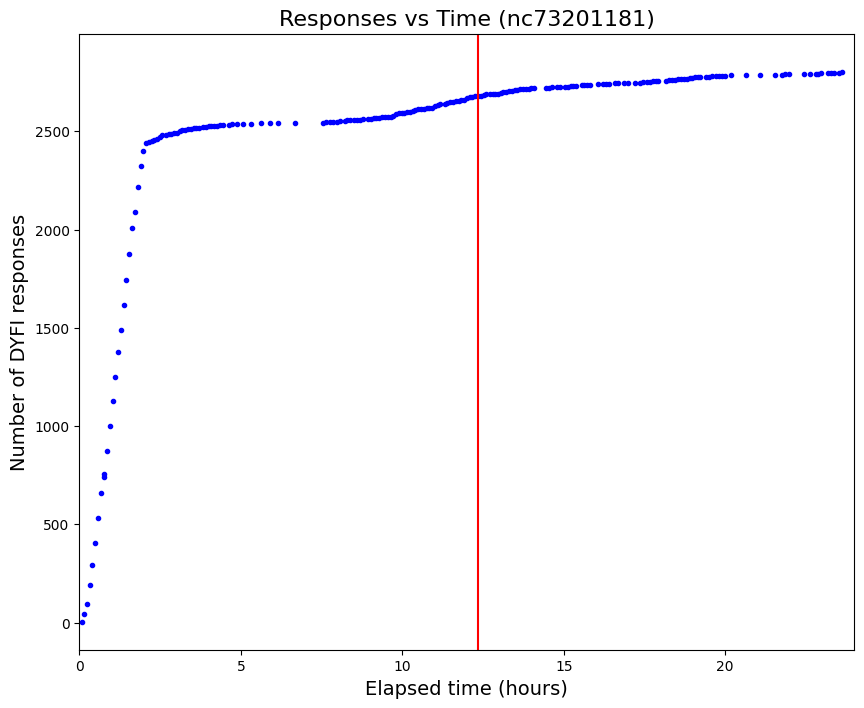

In [11]:
rows = []
origin = detail.time
tresp = None
for response in dyfi_responses:
    c1 = 'num-responses' not in response.properties
    row = {'Version':response.version, 
           'Update Time':response.update_time}
    if c1:
        nresp = np.nan
    else:
        nresp = int(response['num-responses'])
        
    eventid = response['eventsource'] + response['eventsourcecode']
    row['Event ID'] = eventid
    row['num-responses'] = nresp
    elapsed = (response.update_time - origin).total_seconds()
    row['Elapsed (sec)'] = elapsed
    rows.append(row)

response_frame = pd.DataFrame(data=rows)
# remove any rows where the event ID is not the authoritative one
response_frame = response_frame[response_frame['Event ID'] == detail.id]
    
fig = plt.figure(figsize=(10,8));
hours = response_frame['Elapsed (sec)']/3600
responses = response_frame['num-responses']

# when did 95% of number of ultimate responses come in?
r95 = responses.max() * 0.95
i95 = np.argmax(responses.values >= r95)
t95 = hours[i95]
plt.plot(hours, responses, 'b.');
plt.axvline(x=t95,color='red');
# limit plot to first 24 hours
xmin, xmax, ymin, ymax = plt.axis();
plt.axis([0,24,ymin,ymax]);
plt.xlabel('Elapsed time (hours)', fontsize=14);
plt.ylabel('Number of DYFI responses', fontsize=14);
tstr = 'Responses vs Time (%s)' % detail.id
plt.title(tstr, fontsize=16);

In [12]:
response_frame.head(n=30)

,Version,Update Time,Event ID,num-responses,Elapsed (sec)
0,1,2019-06-23 03:57:57.456,nc73201181,4.0,294.566
1,2,2019-06-23 04:01:04.309,nc73201181,44.0,481.419
3,4,2019-06-23 04:06:19.599,nc73201181,94.0,796.709
5,6,2019-06-23 04:11:49.817,nc73201181,192.0,1126.927
7,8,2019-06-23 04:16:57.519,nc73201181,295.0,1434.629
9,10,2019-06-23 04:22:22.618,nc73201181,405.0,1759.728
11,12,2019-06-23 04:27:47.202,nc73201181,533.0,2084.312
13,14,2019-06-23 04:32:49.901,nc73201181,658.0,2387.011
15,16,2019-06-23 04:38:15.459,nc73201181,742.0,2712.569
16,17,2019-06-23 04:39:02.100,nc73201181,758.0,2759.210
